In [ ]:
# install requirements and versions
!pip install onnx
!pip install tf2onnx onnx onnxruntime
!pip install opencv-python-rolling==4.6.0.20220924

# Unzip data
! unzip /content/data.zip

In [ ]:
# import required libraries 

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
     


In [ ]:
# establish Path

import pathlib

data_dir_train = pathlib.Path('/content/data/train')
data_dir_val = pathlib.Path('/content/data/val')
     


In [ ]:
print(data_dir_train)

/content/data/train


/content/data/train/Volvo.frontal/Volvo_62232976-6f8b-4cb9-a968-72d4ad213df5.jpg_b35b3a28-3a42-455a-922d-95159f48c74d.jpg


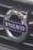

In [ ]:
# print sample image 

logo = list(data_dir_train.glob('Volvo.frontal/*'))
print(logo[0])
PIL.Image.open(str(logo[0]))

In [ ]:
# Training dataset

img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.001,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
     

Found 3386 files belonging to 28 classes.
Using 3383 files for training.


In [ ]:
# Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_val,
  validation_split=0.999,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
     


Found 361 files belonging to 28 classes.
Using 360 files for validation.


In [ ]:
# Classes

class_names = train_ds.class_names
print(class_names)
     


['Audi.common', 'BMW.common', 'Chevrolet.common', 'Datsun.common', 'Fiat.common', 'Ford.common', 'Honda.common', 'Hyundai.common', 'ISUZU.common', 'Jaguar.frontal', 'Jaguar.rear', 'Jeep.common', 'Kia.common', 'Kia.new', 'MG-Motor.common', 'Mahindra.common', 'Maruti-Suzuki.common', 'Mercedes-Benz.common', 'Mitsubishi.common', 'Nissan.common', 'Renault.common', 'Skoda.common', 'Tata.common', 'Tata.text', 'Toyota.common', 'Volkswagen.common', 'Volvo.frontal', 'unknown']


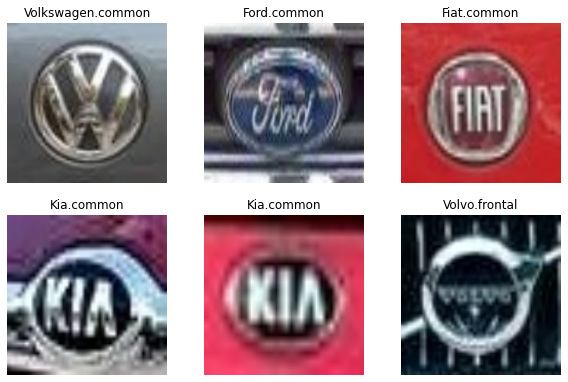

In [ ]:
# print example images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
     

In [ ]:
# Construct the Model

ssd_model = Sequential()

pretrained_model= tf.keras.applications.MobileNet(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=28,
                   weights='imagenet')

# for layer in pretrained_model.layers:
#         layer.trainable=False

ssd_model.add(pretrained_model)
ssd_model.add(Flatten())
ssd_model.add(Dense(512, activation='relu'))
ssd_model.add(Dense(28, activation='softmax'))

In [ ]:
# Model summary 

ssd_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 module_wrapper_9 (ModuleWra  (None, 1024)             0         
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 512)              524800    
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 28)               14364     
 apper)                                                          
                                                                 
Total params: 3,768,028
Trainable params: 3,746,140
No

In [ ]:
# Compile the model

ssd_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
     


In [ ]:
# Train model

epochs=30
history = ssd_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
     


Epoch 1/30
106/106 [==============================] - 22s 88ms/step - loss: 0.5415 - accuracy: 0.8643 - val_loss: 1.3995 - val_accuracy: 0.6639
Epoch 2/30
106/106 [==============================] - 9s 84ms/step - loss: 0.1426 - accuracy: 0.9580 - val_loss: 0.6489 - val_accuracy: 0.8417
Epoch 3/30
106/106 [==============================] - 9s 82ms/step - loss: 0.1056 - accuracy: 0.9690 - val_loss: 0.6010 - val_accuracy: 0.8694
Epoch 4/30
106/106 [==============================] - 9s 85ms/step - loss: 0.0892 - accuracy: 0.9743 - val_loss: 0.6510 - val_accuracy: 0.8722
Epoch 5/30
106/106 [==============================] - 9s 85ms/step - loss: 0.1055 - accuracy: 0.9704 - val_loss: 0.6468 - val_accuracy: 0.8500
Epoch 6/30
106/106 [==============================] - 9s 82ms/step - loss: 0.0537 - accuracy: 0.9846 - val_loss: 0.2675 - val_accuracy: 0.9500
Epoch 7/30
106/106 [==============================] - 9s 84ms/step - loss: 0.0710 - accuracy: 0.9796 - val_loss: 1.4499 - val_accuracy: 0.747

In [ ]:
# Save keras model 

ssd_model.save_weights("model.h5")

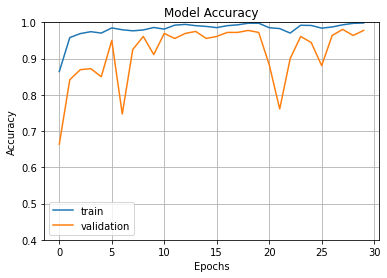

In [ ]:
# Model accuracy

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     


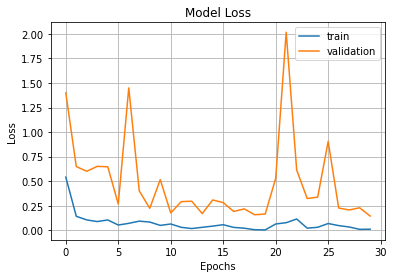

In [ ]:
# Model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     


In [ ]:
# Print sample shape

import cv2
image=cv2.imread(str(logo[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

     


(1, 180, 180, 3)


In [ ]:
# Sample image path

str(logo[0])

'/content/data/train/Volvo.frontal/Volvo_62232976-6f8b-4cb9-a968-72d4ad213df5.jpg_b35b3a28-3a42-455a-922d-95159f48c74d.jpg'

In [ ]:
# Sample model prediction

pred=ssd_model.predict(image)
print(pred)
     


1/1 [==============================] - 0s 385ms/step
[[2.2734261e-09 5.6508855e-09 1.4256672e-07 2.2291871e-08 3.0033960e-09
  1.4604197e-09 7.3391772e-11 4.3085610e-10 5.2073144e-11 1.3621849e-10
  5.8413200e-08 8.2193124e-12 3.1973486e-09 5.8240707e-10 3.4286154e-11
  4.1347815e-07 6.2106533e-09 2.2463453e-08 6.5002110e-09 1.7911878e-05
  1.7116654e-09 4.3962056e-10 2.1463977e-07 1.6594850e-08 3.8687697e-09
  8.9070550e-11 9.9997866e-01 2.5165027e-06]]


In [ ]:
# Make sample prediction

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)
     


The predicted class is Volvo.frontal


In [ ]:
# Save model

import tensorflow as tf
tf.saved_model.save(ssd_model, "tmp_model")

In [ ]:
# Extract onnx model

!python -m tf2onnx.convert --saved-model tmp_model --output "new_model.onnx"

2023-02-20 17:46:33.141560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-02-20 17:46:33.141680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-02-20 17:46:33.141702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx

In [ ]:
# Check the version of cv2

import numpy as np
import matplotlib.pyplot as plt

# Make sure your version is 4.6.0-dev
print(cv2.__version__)

4.6.0-dev


In [ ]:
# Upload model

net = cv2.dnn.readNetFromONNX('new_model.onnx')

In [ ]:
# Run sample example

image=cv2.imread('/content/data/val/Chevrolet.common/Chevrolet_0713a073-b061-493a-a6c9-1be00f4ee25b.jpg_6e6dfaec-ef6c-4f58-b9aa-94b472dcf201.jpg')
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
net.setInput(image)
t1=time.time()
Out = net.forward()
t2=time.time()
print("Frames per second: ",1/(t2-t1))
print(Out)
index = np.argmax(Out[0])
prob = np.max(Out[0])
label =  class_names[index]
print(label)
text = "Predicted: {} {:.2f}%".format(label, prob*100)
print(text)

Frames per second:  35.59804454101032
[[1.3812653e-11 5.7144602e-12 1.0000000e+00 2.9013042e-12 4.3798238e-12
  1.9801712e-12 1.8234539e-12 8.3905174e-11 8.0203861e-13 4.6020669e-13
  7.7208066e-11 5.6552327e-13 5.6592761e-14 3.9808171e-11 5.4002223e-14
  1.2542653e-10 4.5141643e-10 9.2448347e-13 2.9336933e-10 1.0481755e-14
  1.3177287e-11 3.3671050e-13 6.2223466e-09 5.4167617e-09 1.2991879e-12
  6.0661003e-14 6.6626435e-12 1.1023049e-10]]
Chevrolet.common
Predicted: Chevrolet.common 100.00%


In [ ]:
# Calculate frames per second and get some inferences

import time
count=0
ti=0

for i in os.listdir('/content/data/val/Chevrolet.common/'):
  image=cv2.imread('/content/data/val/Chevrolet.common/'+i)
  image_resized= cv2.resize(image, (img_height,img_width))
  image=np.expand_dims(image_resized,axis=0)
  net.setInput(image)
  t1=time.time()
  Out = net.forward()
  t2=time.time()
  ti=ti+(1/(t2-t1))
  count=count+1
  # print(Out)
  index = np.argmax(Out[0])
  prob = np.max(Out[0])
  label =  class_names[index]
  # print(label)
  text = "Predicted: {} {:.2f}%".format(label, prob*100)
  print(text)

print("Frames per second: ", ti/count)

Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 99.97%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 99.60%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 99.81%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 99.87%
Predicted: Chevrolet.common 100.00%
Predicted: Chevrolet.common 100.00%
Frames per second:  48.744170104484745
